# SARIMA

- ARIMA uses parameters (p,q,d)
- SARIMA accepts an additional set of parameters (P,D,Q)m that specifically describe the seasonal components of the model
    - P: Seasonal regression coefficient
    - D: Differencing coefficient
    - Q: Moving average coefficient
    - m: number of rows in each seasonal cycle
    
    
- SARIMA with an X means that is also supports exogenous variables

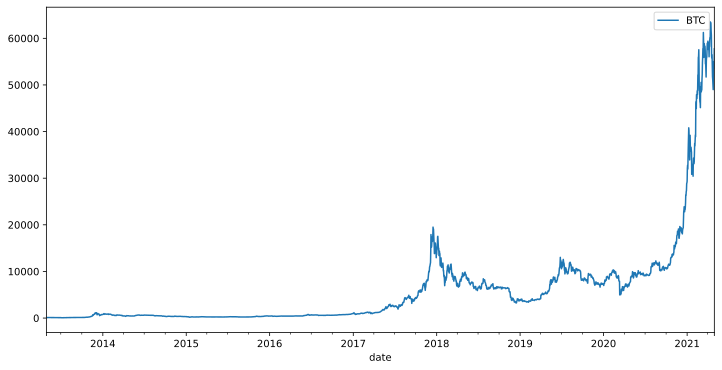

In [4]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-05-01/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_passengers.index.freq = 'MS'
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)
data_births.index.freq = 'D'

data_samples = pd.read_csv(f"{path}samples.csv", parse_dates=True, index_col=0)
data_samples.index.freq = 'MS'
data_trade = pd.read_csv(f"{path}TradeInventories.csv", parse_dates=True, index_col="Date")
data_trade.index.freq = 'MS'

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [6]:
df_co2 = pd.read_csv(f"{path}co2_mm_mlo.csv")
df_co2

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
724,2018,7,2018.542,408.71,408.71
725,2018,8,2018.625,406.99,406.99
726,2018,9,2018.708,405.51,405.51
727,2018,10,2018.792,406.00,406.00


In [7]:
df_co2['date'] = pd.to_datetime({'year': df_co2['year'], "month": df_co2['month'], 'day': 1})
df_co2

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01
...,...,...,...,...,...,...
724,2018,7,2018.542,408.71,408.71,2018-07-01
725,2018,8,2018.625,406.99,406.99,2018-08-01
726,2018,9,2018.708,405.51,405.51,2018-09-01
727,2018,10,2018.792,406.00,406.00,2018-10-01


In [8]:
df_co2 = df_co2.set_index('date')

In [10]:
df_co2.freq = 'MS'
df_co2.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


<AxesSubplot:xlabel='date'>

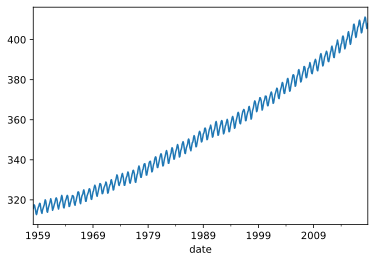

In [12]:
df_co2['interpolated'].plot()

There is clear seasonality and an upward trend!

In [13]:
result = seasonal_decompose(df_co2['interpolated'], model='add')

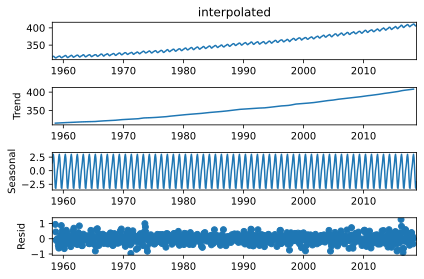

In [16]:
result.plot();

One can take the seasonal component and plot that out to check what the seasonality is.

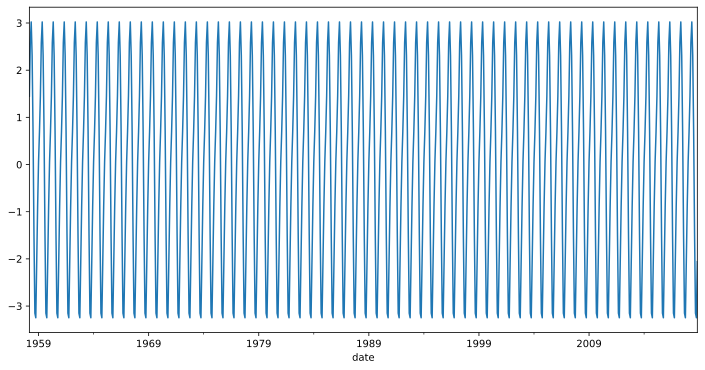

In [18]:
result.seasonal.plot(figsize=(12,6));

In [19]:
auto_arima(df_co2['interpolated'],
           m=12, # monthly data so 12 month per year
           seasonal=True
          ).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.686
Date:                              Thu, 06 May 2021   AIC                            423.371
Time:                                      20:49:37   BIC                            450.913
Sample:                                           0   HQIC                           433.998
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3564      0.036     -9.914      0.000      -0.427      -0.286
ma.L2         -0.0221      0.028     -0.800      0.424      -0.076       0.032
ma.L3         -0.0856      0.027     -3.119      0.002      -0.139      -0.032
ar.S.L12       0.9996      0.000   3023.882      0.000       0.999       1.000
ma.S.L12      -0.8670      0.021    -40.874      0.000      -0.909      -0.825
sigma2         0.0955      0.005     20.545      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.79   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
train = df_co2.iloc[:717]
test = df_co2.iloc[717:]

In [22]:
model = SARIMAX(train['interpolated'], order=(0,1,3), # order for ARIMA
                seasonal_order=(1,0,1,12)# seasonal order
               )
results = model.fit()
results.summary()

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.189
Date:                              Thu, 06 May 2021   AIC                            414.377
Time:                                      21:25:37   BIC                            441.819
Sample:                                  03-01-1958   HQIC                           424.974
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3542      0.035    -10.171      0.000      -0.422      -0.286
ma.L2         -0.0245      0.032     -0.778      0.436      -0.086       0.037
ma.L3         -0.0871      0.033     -2.610      0.009      -0.153      -0.022
ar.S.L12       0.9996      0.000   3034.235      0.000       0.999       1.000
ma.S.L12      -0.8659      0.022    -38.555      0.000      -0.910      -0.822
sigma2         0.0951      0.005     20.395      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.34
Prob(Q):                              0.78   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start, end, typ='levels').rename('SARIMA predictions')

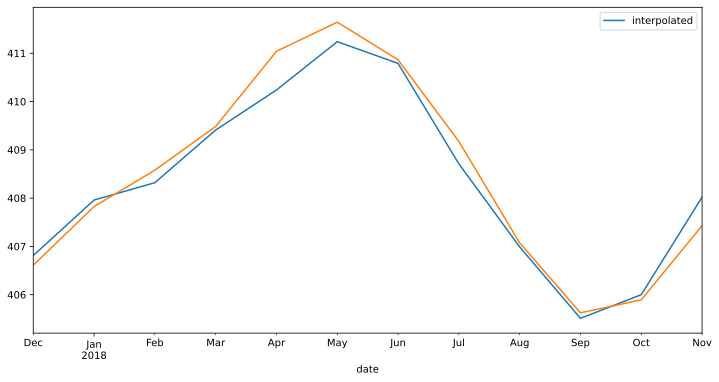

In [26]:
test['interpolated'].plot(figsize=(12,6),legend=True);
predictions.plot();

In [27]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['interpolated'], predictions)

In [28]:
error

0.35808231680723657

# Forecast into the future

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='date'>

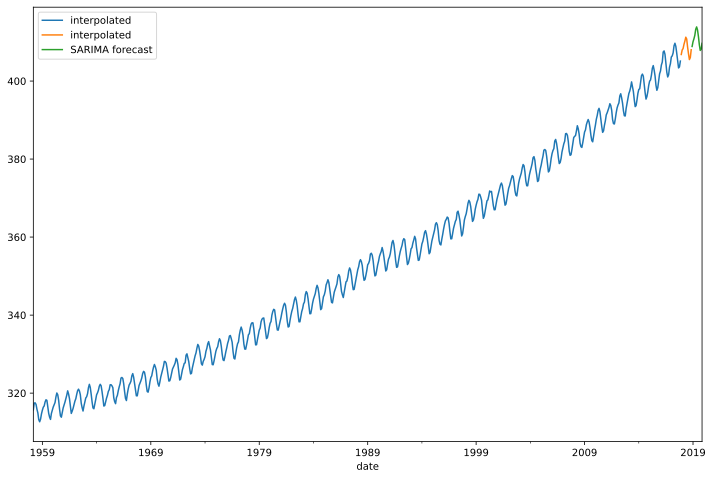

In [30]:
model = SARIMAX(train['interpolated'], order=(0,1,3), # order for ARIMA
                seasonal_order=(1,0,1,12)# seasonal order
               )
results = model.fit()
fcast = results.predict(start=len(df_co2), end=len(df_co2)+11, typ='levels').rename("SARIMA forecast")
train['interpolated'].plot(figsize=(12,8), legend=True)
test['interpolated'].plot(figsize=(12,8), legend=True)
fcast.plot(legend=True)